# Simple CNN Classifier with PyTorch for FashionMNIST dataset

Simple example how to define and train a Convolutional Neural Network using PyTorch.  Dataset used is the FashionMNIST dataset.

## Load Training and Test Data

PyTorch conveniently comes with several built in datasets for practice.   See https://pytorch.org/docs/stable/torchvision/datasets.html


In [1]:
# Import PyTorch
import torch
import torchvision

# Import FashionMNIST dataset and tools
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Transformation from PIL to Tensors
xformr2Tensor = transforms.ToTensor()

training_data = FashionMNIST(root='./data', train=True, download=True, transform=xformr2Tensor)
testing_data = FashionMNIST(root='./data', train=False, download=True, transform=xformr2Tensor)

# Verify we got some data
print("Training Data: ", len(training_data), " images");
print("Testing Data: ", len(testing_data), " images");

# Setup DataLoaders
batch_size = 20
training_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_data_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# FashionMNIST data labels for 10 classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100.0%
100.0%
100.0%
100.0%

Training Data:  60000  images
Testing Data:  10000  images


## Sanity check visualizing a few images
Pick up a few random images and take a peek to make sure we have proper 28x28 pixel grayscale images, as expected


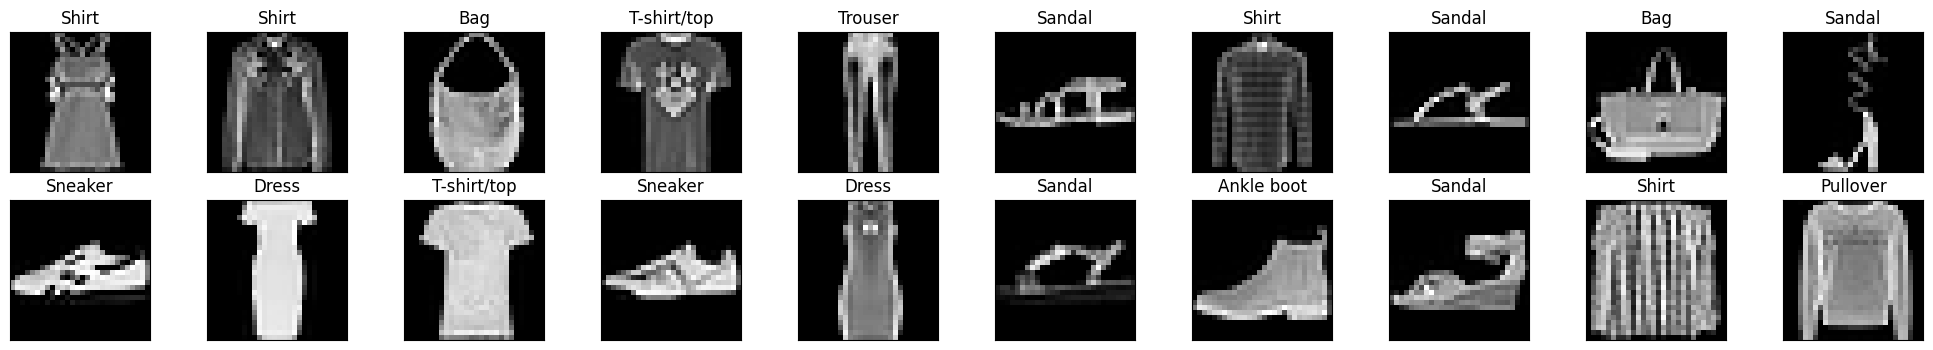

In [5]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Get one batch of images from the training set
image_iter = iter(training_data_loader)
images, labels = next(image_iter)
images = images.numpy()

# Display sample images and their labels
fig = plt.figure(figsize=(25,4))
for i in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(classes[labels[i]])

    

## Define the Convolutional Neural Network (CNN)

Let's define a simple CNN with the followng layers:
1. Convolutional layer
2. Maxpooling layer
3. Convolutional layer
4. Maxpooling layer
5. Fully connected layer
6. Dropout layer
7. Fully connected layer


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
    
        # Define network building blocks
    
        # First Convolutional Layer
        # 1 input, 10 outputs, 3x3 filter kernel
        # Input image size: 28x28
        # Output Width = (Width - Filter_Width + 2*Padding)/Stride + 1
        # Output Width = (28 - 3 + 2*0)/1 + 1 = 26
        # Output image size: 26x26
        self.conv1 = nn.Conv2d(1, 10, 3)
        
        # Maxpool layer, size 2, stride 2
        # Output Image size: 13x13
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second Convolutional Layer:
        # 10 inputs, 20 outputs, 3x3 filter kernel
        # Input image size: 13x13
        # Output Width = (Width - Filter_Width + 2*Padding)/Stride + 1
        # Output Width = (13 - 3 + 2*0)/1 + 1 = 11
        # Output image size: 11x11
        self.conv2 = nn.Conv2d(10, 20, 3)
        
        # After second max pool, image size will be 5 x 5 (5.5 rounded down to 5)
        
        # Fully Connected (Linear) Layer
        self.fc1 = nn.Linear(20*5*5, 50)
        
        # Dropdown to prevent over-fitting
        self.drop = nn.Dropout(p=0.4)
        
        # Final layer with 10 outputs
        self.final = nn.Linear(50,10)
        
    #define the feedforward structure
    def forward(self, x):
        
        # First 2 convolution + ReLU + Max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Prepare for Linear layer
        x = x.view(x.size(0), -1)
        
        # Linear -> Dropout -> Liner
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.final(x)
        
        return x
    
# Instantiate 
net = Net()

# Print out for sanity check
print(net)
        

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (final): Linear(in_features=50, out_features=10, bias=True)
)


## Specify Loss Function and Optimizer to be used

Since this is a classification problem, cross entropy should work well as the Loss function.  Basic Stocastic Gradient Decent (SGD) is a safe choice as the optimizer

In [7]:
import torch.optim as optim

# Cross Entropy should work for a Classification problem
loss_function = nn.CrossEntropyLoss()

# try small learning rate (lr) with some momentum to prevent getting stuck in local minima
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8)

## Just for fun, check what the accuracy is before training ... (With 10 classes the accuracy with ramdon coefficients should be around 10%)

In [8]:
correct = 0
total = 0

for images, labels in testing_data_loader:
    
    # Run thru the network with random weights
    results = net(images)
    
    # Get max output value providing the most likely predicted class
    _, predict = torch.max(results.data, 1)
    
    # Count how many correct classifications
    total += labels.size(0);
    i = 0
    while (i < labels.size(0)):
        if (labels[i].item() == predict[i].item()):
            correct += 1
        i += 1
        
# Determine accuracy
accuracy = 100.0 * correct / total
print("Accuracy without training = ", accuracy)

Accuracy without training =  9.82


## Train the Neural Network

In [9]:
# Define training function
def train(nr_epochs):
    
    # Keep track of loss 
    loss_over_time = []
    
    for cur_epoch in range(nr_epochs):
        
        running_loss = 0.0
        
        for cur_batch, data in enumerate(training_data_loader):
            
            # Retrieve the input images and labels
            inputs, labels = data
            
            # Set the gradients to 
            optimizer.zero_grad()
            
            # Forward pass thru the network
            results = net(inputs)
            
            # Figure out loss
            loss = loss_function(results, labels)
            
            # Backpropagate
            loss.backward()
            optimizer.step()
            
            # Output the loss statistics
            running_loss += loss.item()
            
            if cur_batch % 1000 == 999:   # Print every 1000 batches
                average_loss = running_loss / 1000
                # save stats
                loss_over_time.append(average_loss)
                print("epoch: {}, batch: {}, Average Loss: {}".format(cur_epoch+1, cur_batch+1, average_loss))
                running_loss = 0.0
                
    print("Training Complete!")
    return loss_over_time


# Train for 20 epochs
nr_epochs = 20

# Train
training_loss = train(nr_epochs)

epoch: 1, batch: 1000, Average Loss: 2.2879776289463045
epoch: 1, batch: 2000, Average Loss: 1.7301478551030158
epoch: 1, batch: 3000, Average Loss: 1.0643581887483597
epoch: 2, batch: 1000, Average Loss: 0.9349415630102158
epoch: 2, batch: 2000, Average Loss: 0.8899333438575268
epoch: 2, batch: 3000, Average Loss: 0.8391242647469044
epoch: 3, batch: 1000, Average Loss: 0.7919832797944546
epoch: 3, batch: 2000, Average Loss: 0.7548647074401379
epoch: 3, batch: 3000, Average Loss: 0.7414097333103419
epoch: 4, batch: 1000, Average Loss: 0.7086952041387558
epoch: 4, batch: 2000, Average Loss: 0.6819894132614136
epoch: 4, batch: 3000, Average Loss: 0.6643819217085838
epoch: 5, batch: 1000, Average Loss: 0.6405937118679285
epoch: 5, batch: 2000, Average Loss: 0.6349059389680624
epoch: 5, batch: 3000, Average Loss: 0.6191625744700432
epoch: 6, batch: 1000, Average Loss: 0.602761799260974
epoch: 6, batch: 2000, Average Loss: 0.6186999707520008
epoch: 6, batch: 3000, Average Loss: 0.5834377814

## Visualize how loss changed over epochs

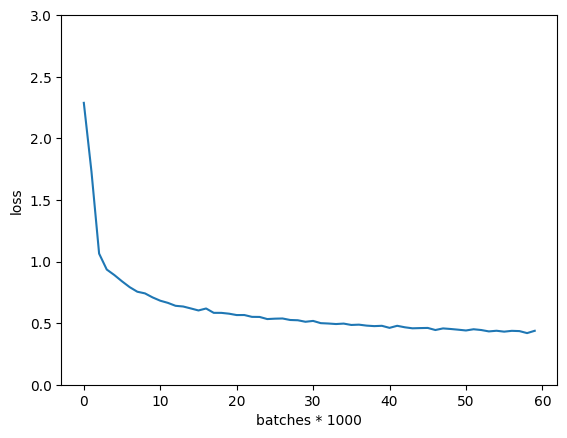

In [10]:
plt.plot(training_loss)
plt.xlabel("batches * 1000")
plt.ylabel("loss")
plt.ylim(0, 3)
plt.show()

## Test the network with test data to determine test accucary

In [11]:
# Initialize lists to track accuracy per class
test_loss = torch.zeros(1)
classes_correct = list(0. for i in range(10))
classes_total = list(0. for i in range(10))

# Set Network to evaluation mode
net.eval()

for cur_batch, data in enumerate(testing_data_loader):
    
            # Retrieve the input images and labels
            inputs, labels = data
                        
            # Forward pass thru the network
            results = net(inputs)
            
            # Figure out loss
            loss = loss_function(results, labels)
            
            # Update average test loss for batch
            test_loss = test_loss + ((torch.ones(1) / (cur_batch +1)) * (loss.data - test_loss))
            
            # Get max output value providing the most likely predicted class
            _, predict = torch.max(results.data, 1)
            
            # Compare predictions to correct labels
            correct = labels.data.view_as(predict)
            
            # Calculate test accuracy per class
            for i in range(batch_size):
                label = labels.data[i]
                if (predict[i] == correct[i]):
                    classes_correct[label] += 1
                classes_total[label] += 1
                
print("Test loss: {:.6f}\n".format(test_loss.numpy()[0]))

for i in range(10):
    if classes_total[i] == 0:
        print("Accuracy for class '%5s': N/A (no training examples)" % classes[i])
    else:
        print("Test accuracy for class '%5s': %2d%% (%2d/%2d)" % ( classes[i], 100*classes_correct[i]/classes_total[i],
                                                         np.sum(classes_correct[i]), np.sum(classes_total[i])))
    

print("\n")
print("Overall Accuracy: %2d%% (%2d/%2d)" % (100. * np.sum(classes_correct) / np.sum(classes_total),
    np.sum(classes_correct), np.sum(classes_total)))

Test loss: 0.374614

Test accuracy for class 'T-shirt/top': 84% (843/1000)
Test accuracy for class 'Trouser': 96% (965/1000)
Test accuracy for class 'Pullover': 79% (795/1000)
Test accuracy for class 'Dress': 89% (894/1000)
Test accuracy for class ' Coat': 74% (745/1000)
Test accuracy for class 'Sandal': 95% (952/1000)
Test accuracy for class 'Shirt': 60% (602/1000)
Test accuracy for class 'Sneaker': 95% (958/1000)
Test accuracy for class '  Bag': 95% (957/1000)
Test accuracy for class 'Ankle boot': 94% (948/1000)


Overall Accuracy: 86% (8659/10000)


## As a sanity check, visualize some sample results, show correct classifications in green and incorrect classifications in red

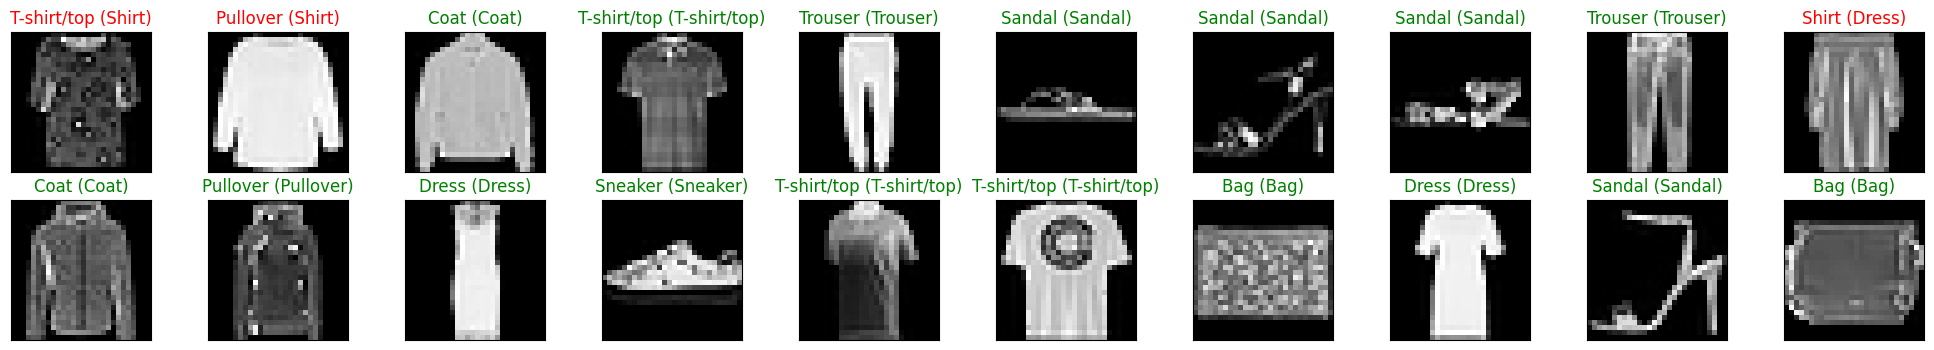

In [14]:
# Get one batch of images from the test set
image_iter = iter(testing_data_loader)
images, labels = next(image_iter)
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# Display images and their predicted labels
fig = plt.figure(figsize=(25,4))
for i in np.arange(batch_size):
    ax = fig.add_subplot(2, int(batch_size/2), i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    if preds[i] == labels[i].item():
        color = 'green'
    else:
        color = 'red'
    ax.set_title("{} ({})".format(classes[preds[i]], classes[labels[i]]),
                 color=color)

## And finally, save the trained model for future use

In [15]:
model_dir = "saved_models/"
model_name = "FashionMNIST_classifier.pt"

# Save
torch.save(net.state_dict(), model_dir+model_name)